This notebook is for creating the base ML model.

In [1]:
model_name = "holidays_weekends" + "_model_files"

In [2]:
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [3]:
module_path = os.path.abspath(os.path.join('../..', 'utils'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

from ml_tools import add_weekends_holidays

d:\CS\summer_project\comp47360-group8\ml_pipeline\utils


In [4]:
df = pd.read_parquet('../../data_evaluation/taxi_trip_data/all_tlc_data_cleaned.parquet')
df.rename({'passenger_count':'busyness', 'datetime':'timestamp'},axis=1, inplace=True)
df.sort_values(by=['timestamp'])
print(df.columns)

Index(['timestamp', 'location', 'busyness'], dtype='object')


In [5]:
df.shape

(7319643, 3)

In [6]:
df.head()

,timestamp,location,busyness
0,2021-01-01,3,132
1,2021-01-01,4,234
2,2021-01-01,5,19
3,2021-01-01,6,37
4,2021-01-01,7,493


In [7]:
df_wth = pd.read_csv("../../data_evaluation/weather_meteostat/meteostat_weather.csv")
df_wth.rename({'time':'timestamp'}, axis=1,inplace=True)
df_wth['timestamp'] = df_wth['timestamp'].astype('datetime64[us]')
df_wth['timestamp'] = pd.to_datetime(df_wth['timestamp'])
df_wth['coco'] = df_wth['coco'].astype('category')
df_wth.sort_values(by=['timestamp'])
df = df.join(df_wth.set_index('timestamp'), on='timestamp', how='left')

In [22]:
df_wth.dtypes

timestamp    datetime64[us]
temp                float64
dwpt                float64
rhum                float64
prcp                float64
pres                float64
coco               category
dtype: object

In [8]:
data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="location",
    timestamp_column="timestamp"
)
print(data.head())

                    busyness  temp  dwpt  rhum  prcp    pres coco
item_id timestamp                                                
3       2021-01-01       132   4.0  -4.0  56.0   0.0  1026.3  4.0
4       2021-01-01       234   4.0  -4.0  56.0   0.0  1026.3  4.0
5       2021-01-01        19   4.0  -4.0  56.0   0.0  1026.3  4.0
6       2021-01-01        37   4.0  -4.0  56.0   0.0  1026.3  4.0
7       2021-01-01       493   4.0  -4.0  56.0   0.0  1026.3  4.0


In [9]:
data.head()

,,busyness,temp,dwpt,rhum,prcp,pres,coco
item_id,timestamp,,,,,,,
3,2021-01-01,132,4.0,-4.0,56.0,0.0,1026.3,4.0
4,2021-01-01,234,4.0,-4.0,56.0,0.0,1026.3,4.0
5,2021-01-01,19,4.0,-4.0,56.0,0.0,1026.3,4.0
6,2021-01-01,37,4.0,-4.0,56.0,0.0,1026.3,4.0
7,2021-01-01,493,4.0,-4.0,56.0,0.0,1026.3,4.0


In [10]:
prediction_length = 3 * 30 * 24 # 3 months prediction window
train_data, test_data = data.train_test_split(prediction_length)

In [11]:
# setting the frequency to h since the data is grouped/collected hourly,
# # added relative path 

predictor = TimeSeriesPredictor(
    freq='h',
    target="busyness",
    eval_metric="MASE",
    prediction_length=prediction_length,
    path=model_name,
    known_covariates_names=['temp', 'dwpt', 'rhum', 'prcp', 'pres', 'coco']
)
print('we made the predictor')

we made the predictor


In [12]:
predictions = predictor.fit(train_data,
                                presets="medium_quality"
                                )


Beginning AutoGluon training...
AutoGluon will save models to 'holidays_weekends_model_files'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.9.19
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       6.53 GB / 15.90 GB (41.1%)
Disk Space Avail:   2133.01 GB / 2794.50 GB (76.3%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'h',
 'hyperparameters': 'light',
 'known_covariates_names': ['temp', 'dwpt', 'rhum', 'prcp', 'pres', 'coco'],
 'num_val_windows': 1,
 'prediction_length': 2160,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'busyness',
 'verbosity': 2}

train_data with frequency 'None' has been resampled to frequency 'h'.
Provided tr

In [13]:
print(predictor.leaderboard())

              model  score_val  pred_time_val  fit_time_marginal  fit_order
0  WeightedEnsemble  -1.120204     711.571955          92.601604          7
1  RecursiveTabular  -1.317460     573.738022         375.807745          3
2     SeasonalNaive  -1.339581       1.099038           5.655304          2
3     DirectTabular  -2.062017      80.539003         234.728456          4
4             Theta  -2.269781      52.278913           6.340437          6
5             Naive  -2.354159       3.916980           6.082902          1
6               ETS  -9.005625     207.350924           6.445264          5


dtype('O')

In [25]:
future_index = get_forecast_horizon_index_ts_dataframe(train_data, prediction_length=prediction_length, freq='H')
future_timestamps = future_index.get_level_values("timestamp")
known_covariates = pd.DataFrame(index=future_index)
df_wth = df_wth.set_index("timestamp")
known_covariates = known_covariates.join(df_wth, on='timestamp', how='left')

c:\Users\Daniel\miniconda3\envs\comp47360_autogluon\lib\site-packages\autogluon\timeseries\utils\forecast.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)


In [26]:
predictions = predictor.predict(train_data, known_covariates=known_covariates)
print(predictions)

data with frequency 'None' has been resampled to frequency 'h'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


                                   mean         0.1         0.2         0.3  \
item_id timestamp                                                             
3       2024-01-01 23:00:00  152.192019  122.381532  132.502095  139.808198   
        2024-01-02 00:00:00  101.104883   67.002383   78.696175   87.116081   
        2024-01-02 01:00:00  120.857254   83.441519   96.266333  105.481967   
        2024-01-02 02:00:00   97.029621   57.146586   70.818092   80.724254   
        2024-01-02 03:00:00   76.971543   34.406434   48.989745   59.545724   
...                                 ...         ...         ...         ...   
110     2022-04-23 13:00:00    1.285698  -12.695460   -7.896863   -4.430578   
        2022-04-23 14:00:00    1.291693  -12.691333   -7.889403   -4.420820   
        2022-04-23 15:00:00    1.324524  -12.663829   -7.858736   -4.392708   
        2022-04-23 16:00:00    1.320963  -12.671011   -7.860657   -4.394528   
        2022-04-23 17:00:00    1.336580  -12.672830 

data with frequency 'None' has been resampled to frequency 'h'.


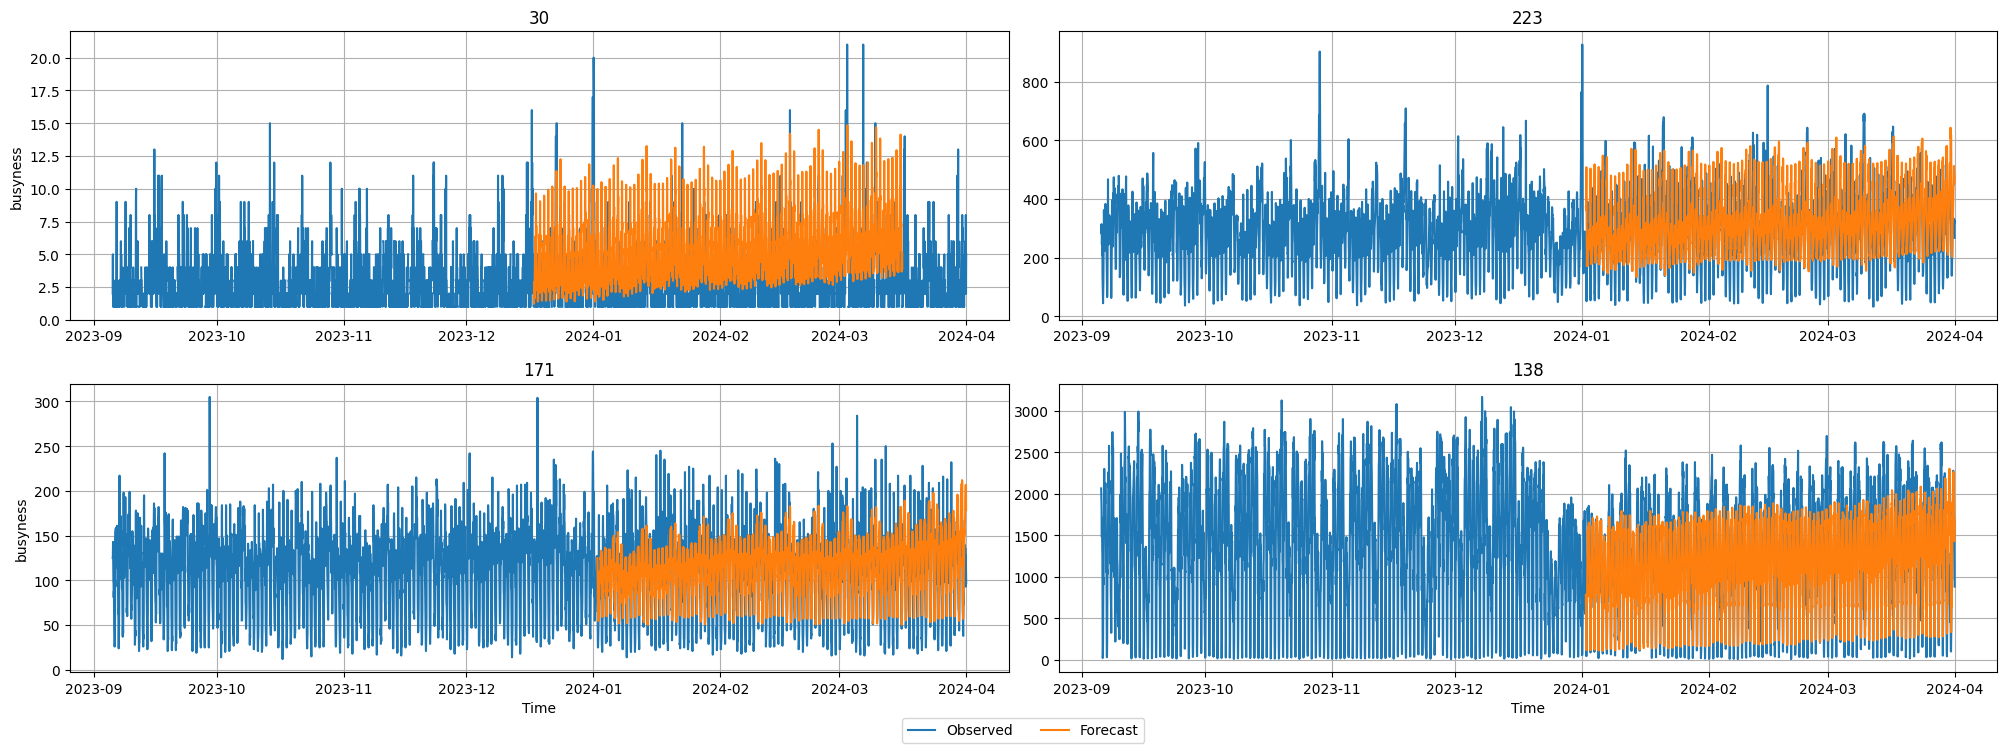

In [27]:
plot = predictor.plot(test_data, predictions, quantile_levels=[0.5],  max_history_length=5000,  max_num_item_ids=4)


data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.


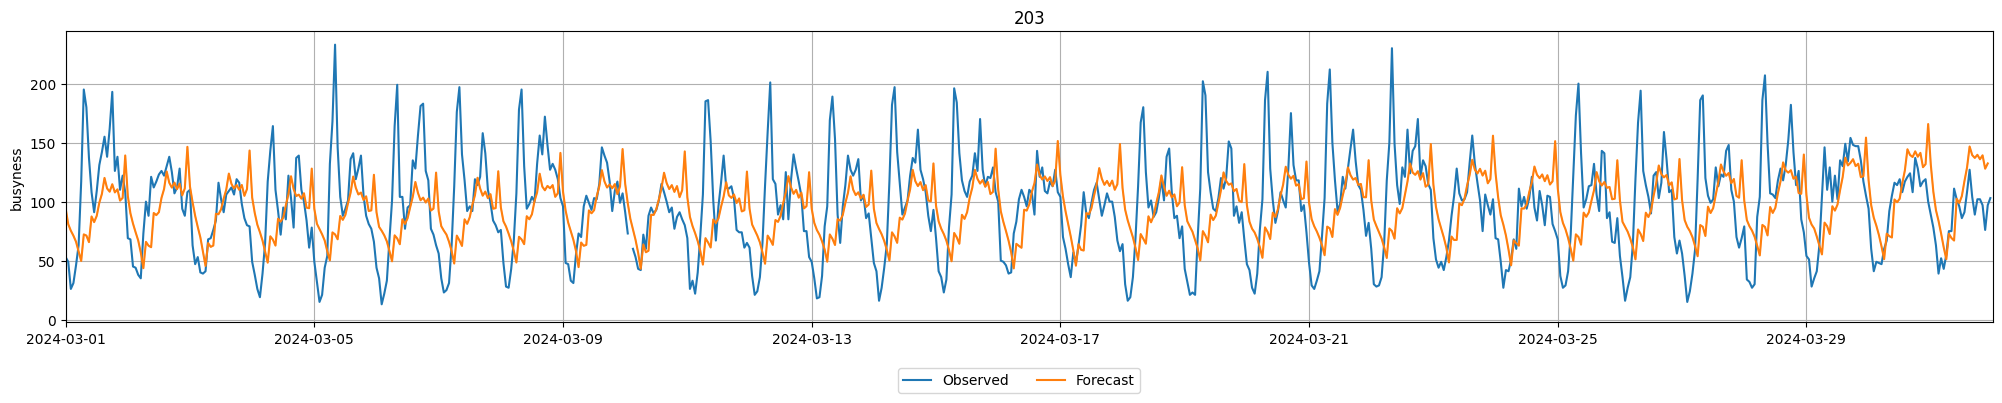

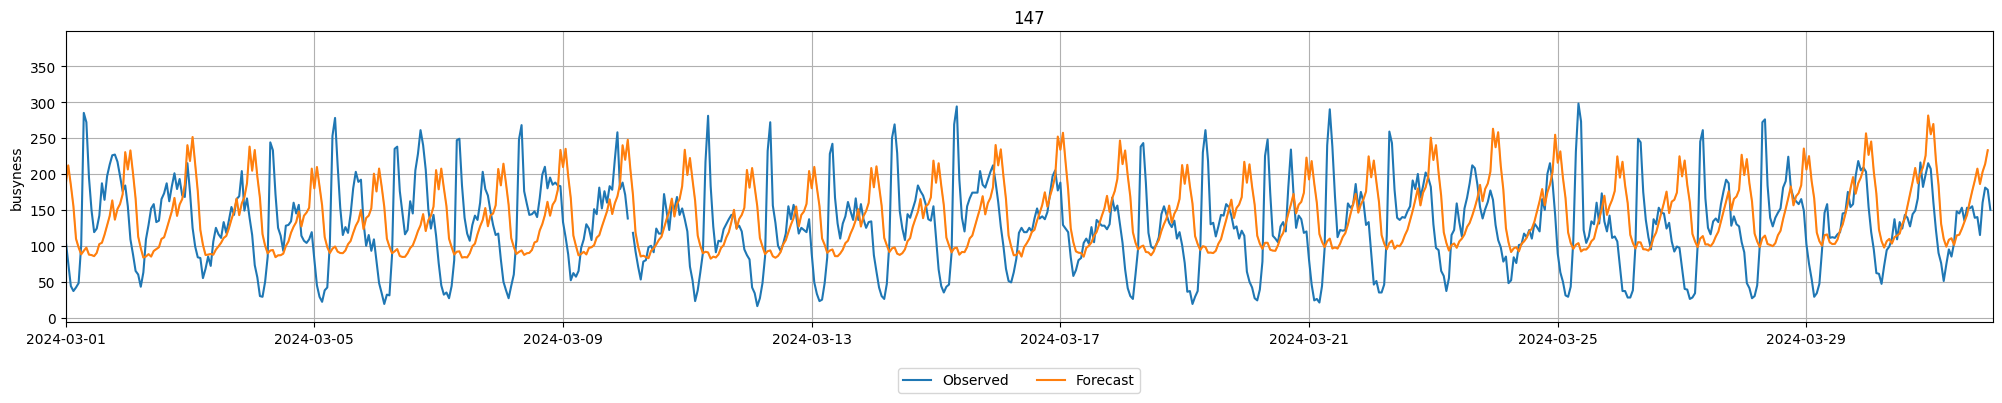

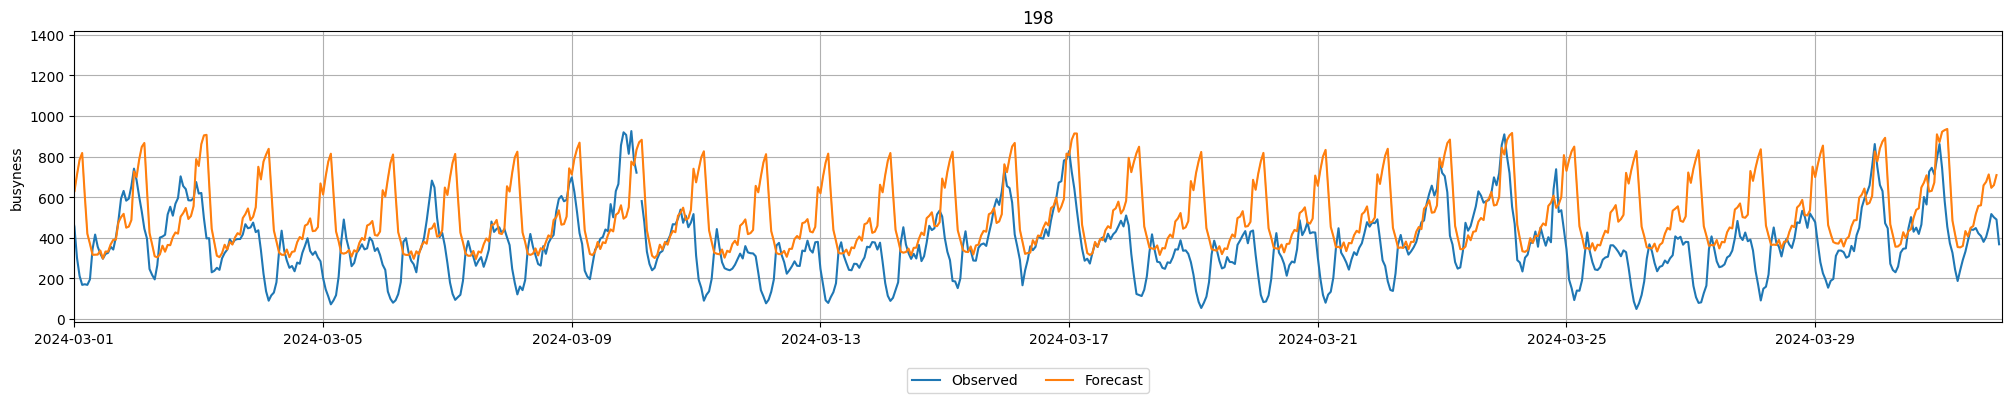

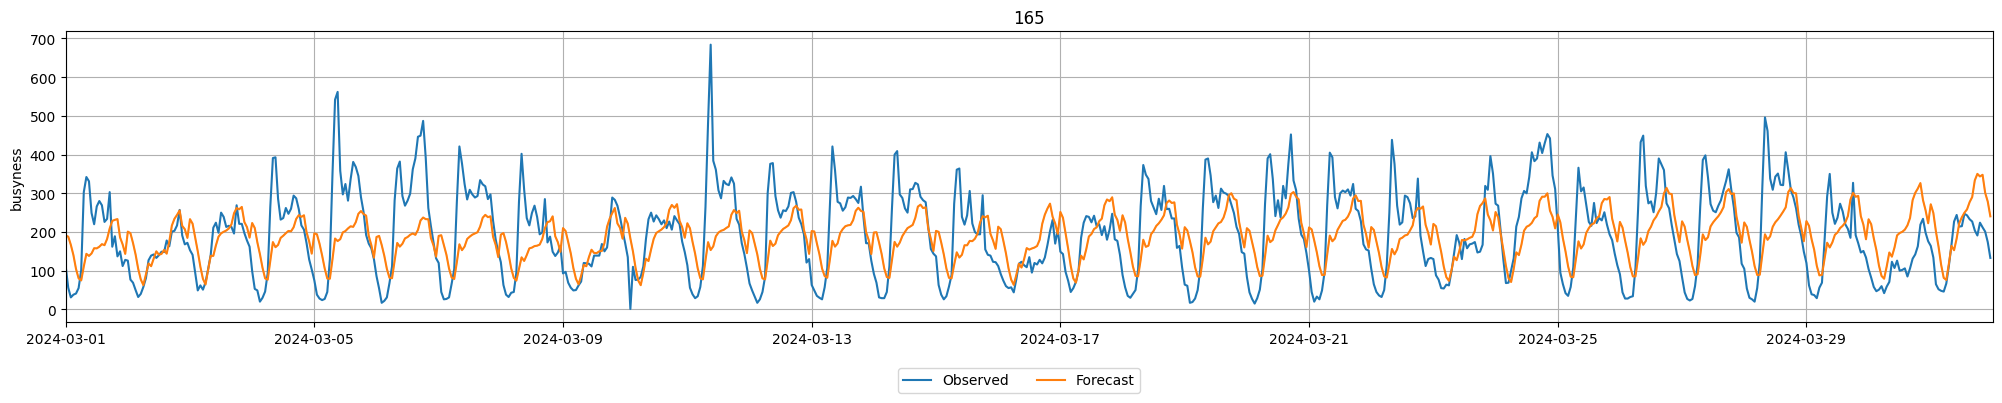

In [28]:
xmin = pd.Timestamp('2024-03-01 00:00:00')
xmax = pd.Timestamp('2024-03-31 23:59:59')
item_ids = [203, 147, 198, 165]
for id in item_ids:
    plot = predictor.plot(test_data, predictions, quantile_levels=[0.5],  max_history_length=5000,  item_ids=[id])
    ax = plot.gca()
    ax.set_xlim([xmin, xmax])
plt.show()

In [29]:
predictor.evaluate(test_data)

data with frequency 'None' has been resampled to frequency 'h'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


{'MASE': -2.027661064190472}